# Text Generation using RNN :

### Create the Environment :
Since we work with text data, an Embedding layer will be required. Since we build LSTM recurrent neural networks, an LSTM layer will be required. In addition, a Dense layer will be of use to develop a classification head.

In [1]:
import numpy as np
import tensorflow as tf
import warnings
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter(action='ignore',category=FutureWarning)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt

Num GPUs Available:  1


### Downloading Text file :

In [2]:
file_URL = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
file_name= "shakespeare.txt"
# get the file path
path = keras.utils.get_file(file_name, file_URL)

In [3]:
raw = open(path, 'rb').read()
print(raw[250:400])

b"\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it "


In [4]:
text = raw.decode(encoding='utf-8')
print(text[250:400]) 


All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [5]:
len(text)

1115394

### Vectorize Word into Integers :
A deep learning model can not accept text characters as inputs. It should be encoded into integers that a model can understand and process with.

In [6]:
# unique characters
vocabulary = np.array(sorted(set(text)))
len(vocabulary) 

65

In [7]:
print(vocabulary)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


**Defining a Tokenizer to assign integer to each token :**

In [8]:
tokenizer = {char:i for i,char in enumerate(vocabulary)}

In [9]:
for i in range(20):
    char = vocabulary[i]
    token = tokenizer[char]
    print('%4s : %4d'%(repr(char),token))

'\n' :    0
 ' ' :    1
 '!' :    2
 '$' :    3
 '&' :    4
 "'" :    5
 ',' :    6
 '-' :    7
 '.' :    8
 '3' :    9
 ':' :   10
 ';' :   11
 '?' :   12
 'A' :   13
 'B' :   14
 'C' :   15
 'D' :   16
 'E' :   17
 'F' :   18
 'G' :   19


In [10]:
vector = np.array([tokenizer[char] for char in text])
print('\nSample Text \n')
print('-'*70)
print(text[:100])
print('-'*70)
print('\n\nCorresponding Integer Vector \n')
print('-'*70)
print(vector[:100])
print('-'*70)


Sample Text 

----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
----------------------------------------------------------------------


Corresponding Integer Vector 

----------------------------------------------------------------------
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
----------------------------------------------------------------------


Text with one million encoded characters can not be fed into a model as such. Since we predict characters, the text must be broken down into sequences of some predefined length and then fed into the model. Use TensorFlow’s batch method to create sequences of 100 characters each. Prior to that, convert the NumPy arrays into tensors to make further processes using TensorFlow.

In [11]:
# convert into tensors
vector = tf.data.Dataset.from_tensor_slices(vector)
# make sequences each of length 100 characters
sequences = vector.batch(100, drop_remainder=True)

In [12]:
def prepare_dataset(seq):
    input_vector = seq[:-1]
    target_vector = seq[1:]
    return input_vector, target_vector
dataset = sequences.map(prepare_dataset)

In [13]:
for inp, tar in dataset.take(2):
    print(inp.numpy())
    print(tar.numpy())
    inp_text = ''.join(vocabulary[inp])
    tar_text = ''.join(vocabulary[tar])
    print(repr(inp_text))
    print(repr(tar_text))

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59]
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
[ 1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39 58 46 43 56
  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47 57 46 12  0
  0 13 50 50 10  0 30 43 57 53

### Batch and Pre-fetch data :
Model will be trained with Stochastic Gradient Descent (SGD) based optimizer Adam. It requires the input data to be batched. Further, TensorFlow’s prefetch method helps training with optimized memory. It fetches data batches just before the training requires them. We prefer not to shuffle the data to retain the contextual order of sequences.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
# buffer size 10000
# batch size 64
data = dataset.batch(64, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)
# steps per epoch is number of batches available
STEPS_PER_EPOCH = len(sequences)//64
for inp, tar in data.take(1):
    print(inp.numpy().shape)
    print(tar.numpy().shape)

(64, 99)
(64, 99)


In [15]:
for inp, tar in data.take(2):
    print(inp.numpy())
    print(tar.numpy())
    inp_text = ''.join(vocabulary[inp][0])
    tar_text = ''.join(vocabulary[tar][0])
    print(repr(inp_text))
    print(repr(tar_text))

[[18 47 56 ...  0 37 53]
 [ 1 39 56 ...  1 63 53]
 [ 1 49 52 ... 58  1 59]
 ...
 [ 1 57 51 ...  1 39 50]
 [ 1 39 58 ...  1 61 43]
 [50  8  0 ... 42 47 58]]
[[47 56 57 ... 37 53 59]
 [39 56 43 ... 63 53 59]
 [49 52 53 ...  1 59 57]
 ...
 [57 51 39 ... 39 50 50]
 [39 58  1 ... 61 43 50]
 [ 8  0  0 ... 47 58  1]]
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
[[59 54  6 ... 58 53  5]
 [12  0  0 ...  1 45 53]
 [42  1 40 ...  1 56 47]
 ...
 [57  1 56 ... 58 46 43]
 [ 1 52 53 ... 26 21 33]
 [10  0 24 ...  6  1 46]]
[[54  6  1 ... 53  5 58]
 [ 0  0 18 ... 45 53 53]
 [ 1 40 43 ... 56 47 45]
 ...
 [ 1 56 53 ... 46 43 51]
 [52 53 58 ... 21 33 31]
 [ 0 24 43 ...  1 46 43]]
"up, that all\nFrom me do back receive the flour of all,\nAnd leave me but the bran.' What say you to'"
"p, that all\nFrom me do back receive the flour of all

### Build an RNN Model: 
Recurrent neural networks are good at modeling time-dependent data because of its ability to retain time-steps based information in memory. Since texts have contextual information that are determined purely by order of the words, natural language processing heavily relies on sequence modeling architectures such as RNN. Here, an LSTM (Long Short-Term Memory) layers-based recurrent neural network is developed to model the task. While implementing LSTM layers, we enable stateful argument as True to keep the time-step memory of previous states while learning with consequent batches in an epoch. 

In [16]:
model = keras.Sequential([
     # Embed len(vocabulary) into 64 dimensions
     Embedding(len(vocabulary), 64, batch_input_shape=[64,None]),
     # LSTM RNN layers
     LSTM(512, return_sequences=True, stateful=True),
     LSTM(512, return_sequences=True, stateful=True),
     # Classification head
     Dense(len(vocabulary))
])
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 64)            4160      
                                                                 
 lstm (LSTM)                 (64, None, 512)           1181696   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           2099200   
                                                                 
 dense (Dense)               (64, None, 65)            33345     
                                                                 
Total params: 3,318,401
Trainable params: 3,318,401
Non-trainable params: 0
_________________________________________________________________


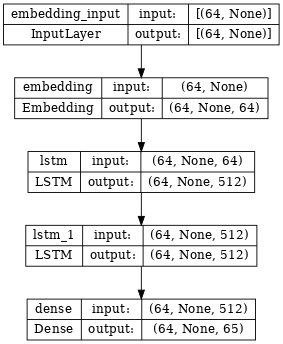

In [17]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [18]:
# test whether the untrained model performs good
for example_inp, example_tar in data.take(1):
    example_pred = model(example_inp)
    print(example_tar.numpy().shape)
    print(example_pred.shape) 

(64, 99)
(64, 99, 65)


The target shape is (64, 99), which refers to the batch size and the number of characters in that sequence. The last shape, 65, in the prediction refers to the size of the vocabulary. The model predicts the probability of occurrence of each character in the vocabulary. The character with a higher probability has more possibility to be the next character.

In [19]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(data, epochs=10, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
174/174 [==============================] - 20s 99ms/step - loss: 3.1511
Epoch 2/10
174/174 [==============================] - 17s 100ms/step - loss: 2.3301
Epoch 3/10
174/174 [==============================] - 18s 101ms/step - loss: 2.0467
Epoch 4/10
174/174 [==============================] - 18s 102ms/step - loss: 1.8529
Epoch 5/10
174/174 [==============================] - 18s 103ms/step - loss: 1.7093
Epoch 6/10
174/174 [==============================] - 19s 108ms/step - loss: 1.6039
Epoch 7/10
174/174 [==============================] - 19s 111ms/step - loss: 1.5261
Epoch 8/10
174/174 [==============================] - 20s 112ms/step - loss: 1.4674
Epoch 9/10
174/174 [==============================] - 20s 114ms/step - loss: 1.4212
Epoch 10/10
174/174 [==============================] - 20s 114ms/step - loss: 1.3824


### Model Performance Evaluation :

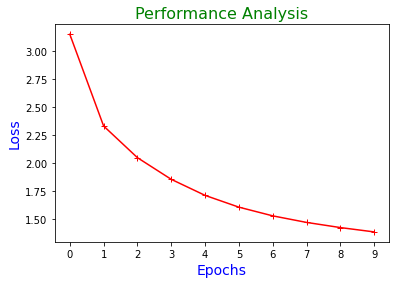

In [20]:
plt.plot(history.history['loss'], '+-r')
plt.title('Performance Analysis', size=16, color='green')
plt.xlabel('Epochs', size=14, color='blue')
plt.ylabel('Loss', size=14, color='blue')
plt.xticks(range(10))
plt.show() 

Loss keeps on falling down even till the 10th epoch. It suggests that the model should be trained for more epochs until convergence occurs. The smoothness in the loss curve suggests that the learning rate is proper for this model configuration.

### Inference – Next Character Prediction :
The most awaited part of this task is predicting the next character with the trained model. We can input the model some characters (probably a word) such that it will iteratively predict the next 1000 characters.

Before starting prediction with the model, we should reset the model states that were stored in the memory during the last epoch training. However, resetting state memories will not affect the model’s weights.

In [21]:
# reset previous states of model
model.reset_states() 

Make predictions by providing the model ‘ANTHONIO:’ as input characters. Nevertheless, the model expects data in three dimensions: the first dimension being the batch size, 64. Vectorize the input characters, expand the dimensions, broadcast the same vector 64 times to obtain a batch of size 64 sequences. Predictions are made based on the logits output by the model. This can be sensitively adjusted by tuning a hyper-parameter called temperature, which refers to the level of randomness in choosing the probable outcome.

In [22]:
sample = 'ANTHONIO:'

# vectorize the string
sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector

# convert into tensor of required dimensions
sample_tensor = tf.expand_dims(sample_vector, 0) 
# broadcast to first dimension to 64 
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

In [23]:
# predict next 1000 characters
# temperature is a sensitive variable to adjust prediction
temperature = 0.6

for i in range(1000):
    pred = model(sample_tensor)
    # reduce unnecessary dimensions
    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)
    # broadcast to first dimension to 64 
    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

In [24]:
# convert the integers back to characters
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:
Now, if the truth of the world:
But thou wilt stand hanged the earth.

TRANIO:
That you not is the weary. O, thou hast dead?

LUCENTIO:
But this is the dishonour master with this?

BIONDELLO:
The banns of grave to hear the world.

GRUMIO:
Thou takest thou that thou dost speak and boward
in depending thought they fly;
What will you see him that thou hast offended.

ANTONIO:
I cannot thou have welcome thee with them.

ANTONIO:
Lack; the stricken child, and sent the best and night.

BAPTISTA:
Now, to the sea, she shall be sorry should believe thee to be attend;
And then, who have been so better thing.

PETRUCHIO:
Call her hand, his tale,
And therefore farewell: if you did not
more than me how thou comest with the house of our book.

DUKE VINCENTIO:
Besides the strike confession of his old
That we that fair and here in the prince of my
sight is she shall be both husband'd yourselves.

BAPTISTA:
I know you the house of my wife and say the day
That he shall find me spectagunes, sir